A notebook to interrogate any potential correlations between calculations of the lineage score (mean, variance, median, max) and a cluster's RMSD comparison to its AlphaFold structure.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
import scipy as sp

plt.style.use('science')

In [2]:
'''
We need to wrangle our RMSD data a bit before we can make any calculations.
'''

rmsd = pd.read_csv('./project_pipeline/data/two-state_af_cf_compared.tsv', sep='\t')

# Create a cluster column from the filename column
rmsd['cluster'] = rmsd['cf_filename'].apply(lambda x: x.split('_')[1])

# We only need a subset of the columns
rmsd = rmsd[['uniprot', 'cluster', 'complex_rmsd', '2_comp']]

rmsd = rmsd.rename(columns={'complex_rmsd': 'Complex RMSD', '2_comp': 'IMAE'})
rmsd.head()

,uniprot,cluster,Complex RMSD,IMAE
0,O08967,U10-005,29.963,32.699
1,O08967,031,30.960,23.498
2,O08967,U10-001,29.368,27.870
3,O08967,U100-004,31.939,51.425
4,O08967,029,29.910,22.467


In [3]:
'''
Now we'll merge the RMSD data with the lineage scores.
'''

lineage = pd.read_csv('./project_pipeline/data/lineage_scores.csv')

lineage.head()

# Merge the RMSD and lineage data
merged = pd.merge(rmsd, lineage, on=['uniprot', 'cluster'])

merged.head()

,uniprot,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length
0,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A812VSQ5,2952.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33630, 2864, 89954, 25...",2,30,8
1,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A2G8JTM8,307972.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",7,30,15
2,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001469F9E4,52239.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,31
3,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A8C7Z9G0,183150.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33
4,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001E1BC1D8,35525.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,20


Let's look at some various measures. First we'll look at the variance.

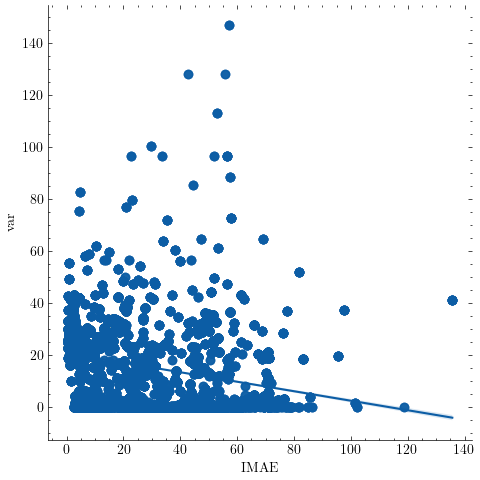

In [4]:
var = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('var')

merged['var'] = var

merged.head()

sns.lmplot(data=merged, x='IMAE', y='var')

How about the mean?

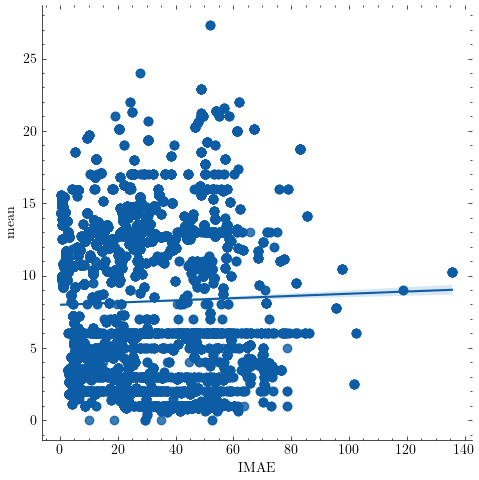

In [5]:
mean = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('mean')

merged['mean'] = mean

sns.lmplot(data=merged, x='IMAE', y='mean')

plt.show()

The max?

31115


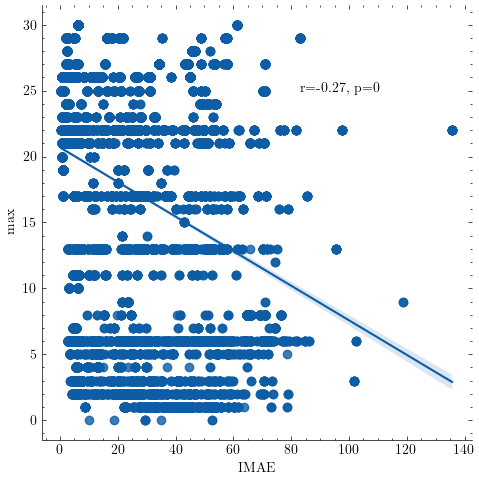

In [6]:
max = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

merged['max'] = max

g = sns.lmplot(data=merged, x='IMAE', y='max')

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['max'], data['IMAE'])
    ax = plt.gca()
    ax.text(.6, .8, 'r={:.2f}, p={:.8g}'.format(r, p),
            transform=ax.transAxes)

g.map_dataframe(annotate)
print(len(merged))

plt.show()

So, only the max shows any sort of signal. Is this confounded by the number of sequences? 

In [7]:
# Need to count the number of unirefs per cluster

counts = merged.groupby(['cluster', 'uniprot']).size().reset_index(name='counts')

print(counts)

# Now we can merge the counts with the lineage scores
lineage_counts = pd.merge(merged, counts, on=['uniprot', 'cluster'])

# Get rid of any lineage scores of 0, those didn't return taxon when queried.
lineage_counts = lineage_counts[lineage_counts['lineage_score'] > 0]

lineage_counts.head()

maxc = counts.max()

       cluster uniprot  counts
0          000  O08967     395
1          000  O60741       2
2          000  P07038       2
3          000  P12931      17
4          000  P22681      97
...        ...     ...     ...
1440  U100-009  P62826      55
1441  U100-009  Q6GQQ9      90
1442  U100-009  Q8NQJ3      50
1443  U100-009  Q96BN8      93
1444  U100-009  Q9Y6K1      86

[1445 rows x 3 columns]


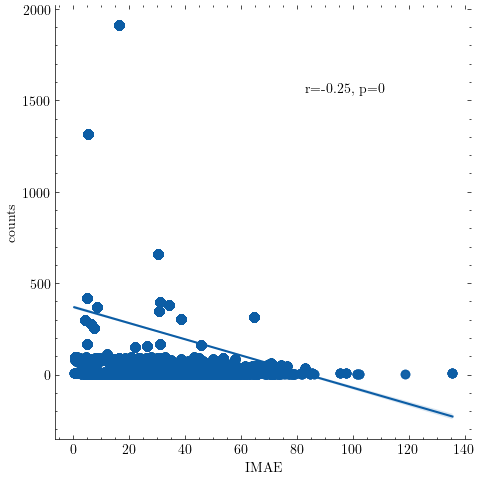

In [8]:
# Plot the relationship between the number of unirefs and the lineage score
g6 = sns.lmplot(data=lineage_counts, x='IMAE', y='counts')

def annotate(data, **kws):
    r, p = sp.stats.spearmanr(data['counts'], data['IMAE'])
    ax = plt.gca()
    ax.text(.6, .8, 'r={:.2f}, p={:.8g}'.format(r, p),
            transform=ax.transAxes)

g6.map_dataframe(annotate)

plt.show()

The correlation is sliiiiiightly weaker, but not by much.
Let's bin the data.

What does our distribution of counts look like?

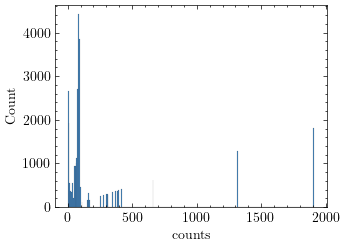

In [9]:
sns.histplot(data=lineage_counts, x='counts')

plt.show()

Pretty lopsided. Let's define some bins and see what it looks like.

In [10]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 2000]

lineage_counts['bins'] = pd.cut(lineage_counts['counts'], bins)

max = lineage_counts.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

lineage_counts['max'] = max

lineage_counts.head()

,uniprot,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,var,mean,max,counts,bins
0,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A812VSQ5,2952.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33630, 2864, 89954, 25...",2,30,8,20.666667,7.0,13,7,"(0, 25]"
1,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A2G8JTM8,307972.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",7,30,15,20.666667,7.0,13,7,"(0, 25]"
2,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001469F9E4,52239.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,31,20.666667,7.0,13,7,"(0, 25]"
3,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A8C7Z9G0,183150.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33,20.666667,7.0,13,7,"(0, 25]"
4,O08967,U10-005,29.963,32.699,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001E1BC1D8,35525.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,20,20.666667,7.0,13,7,"(0, 25]"


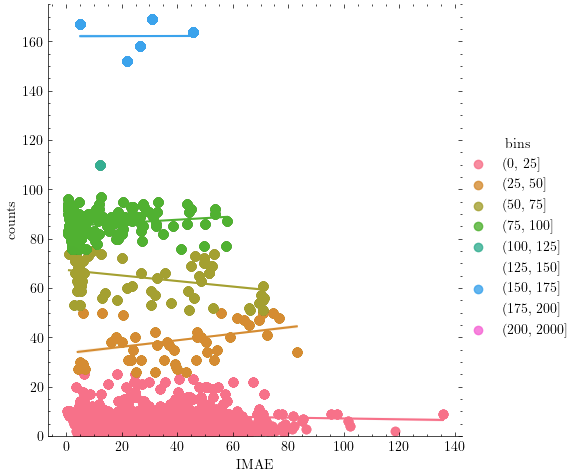

In [11]:
sns.lmplot(data=lineage_counts, x='IMAE', y='counts', hue='bins')

plt.ylim(0, 175)

plt.show()

So it seems like, within the bins, there is no correlation between IMAE and the number of sequences. Interesting.

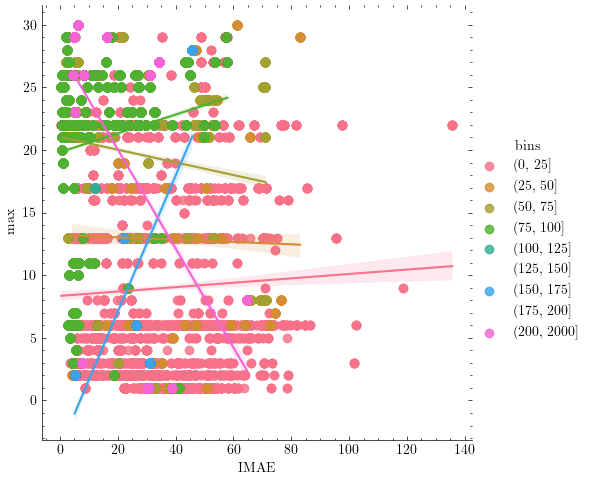

In [12]:
sns.lmplot(data=lineage_counts, x='IMAE', y='max', hue='bins')

plt.show()

Do I have any clusters with most taxa lower on the tree, but with higher number of counts?

In [13]:
many_bac = lineage_counts[(lineage_counts['cluster_lineage_length'] <= 8) & (lineage_counts['counts'] > 50)]

print(len(many_bac))

print(many_bac['cluster_lineage'])

3894
15       [131567, 2759, 2698737, 33630, 2864, 2964, 668...
62                                                [131567]
70       [131567, 2759, 2698737, 33630, 2864, 89954, 25...
76       [131567, 2759, 554915, 555280, 1485085, 555392...
129      [131567, 2759, 554915, 2605435, 2605334, 26818...
                               ...                        
28675               [131567, 2, 1783272, 1154676, 2599633]
28676                             [131567, 2, 1224, 81684]
28679    [131567, 2, 1783272, 201174, 1760, 85007, 1762...
28680    [131567, 2, 1783272, 67819, 1663419, 1663425, ...
28681    [131567, 2, 1783272, 201174, 1760, 85009, 8501...
Name: cluster_lineage, Length: 3894, dtype: object


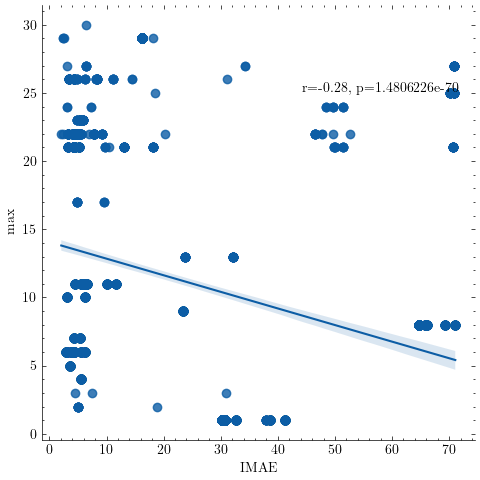

In [14]:
g8 = sns.lmplot(data=many_bac, x='IMAE', y='max')

def annotate(data, **kws):
    r, p = sp.stats.spearmanr(data['max'], data['IMAE'])
    ax = plt.gca()
    ax.text(.6, .8, 'r={:.2f}, p={:.8g}'.format(r, p),
            transform=ax.transAxes)

g8.map_dataframe(annotate)
plt.show()

How about clusters with large lineage scores, but few sequences? (This will be quite telling)

In [28]:
few_euk = lineage_counts[(lineage_counts['lineage_score'] >= 20) & (lineage_counts['counts'] < 50)]

print(len(few_euk))

433


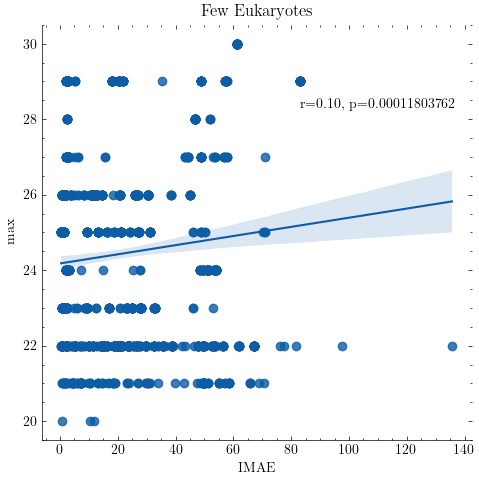

In [27]:
g9 = sns.lmplot(data=few_euk, x='IMAE', y='max')

plt.title('Few Eukaryotes')
g9.map_dataframe(annotate)
plt.show()

Find the best-matching clusters for both the "active" and "autoinhibited" structures for my two-state proteins.

Look at the correlation for all structures.

In [15]:
# cf_pdb = pd.read_csv('./project_pipeline/data/two-state_cf_pdb_compared.tsv', sep='\t')

# cf_pdb = cf_pdb[['uniprot', 'cluster', 'region_1', 'region_2', '2_comp', 'pdb', 'state', 'conformation']]

# cf_pdb = cf_pdb.rename(columns={'2_comp': 'IMAE'})

# active = cf_pdb[cf_pdb['state'] == 'Active']

# auto = cf_pdb[cf_pdb['state'] == 'Autoinhibited']

# # Merge the lineage scores in

# all_merged = pd.merge(cf_pdb, lineage, on=['uniprot', 'cluster'])

# active_merged = pd.merge(active, lineage, on=['uniprot', 'cluster'])

# auto_merged = pd.merge(auto, lineage, on=['uniprot', 'cluster'])


In [16]:
# ac_max = active_merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

# active_merged['max'] = ac_max

# au_max = auto_merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

# auto_merged['max'] = au_max

# auto_merged = auto_merged.rename(columns={'2_comp': 'IMAE', 'state_x': 'state', 'conformation_x': 'conformation', 
#                                   'state_y': 'af_state', 'conformation_y': 'af_conformation'})

# active_merged = active_merged.rename(columns={'2_comp': 'IMAE', 'state_x': 'state', 'conformation_x': 'conformation', 
#                                   'state_y': 'af_state', 'conformation_y': 'af_conformation'})

In [17]:
'''
First we find the minimum for the active structures
'''

cf_pdb = pd.read_csv('./project_pipeline/data/two-state_cf_pdb_compared.tsv', sep='\t')

active = cf_pdb[cf_pdb['state'] == 'Active']

auto = cf_pdb[cf_pdb['state'] == 'Autoinhibited']

# Find the minimum 2_comp for each protein's Active state structure.
pmin = active.groupby('uniprot').agg({'2_comp': 'min'})

# Filter our active dataframe to those minimums
active = pd.merge(pmin, active, on=['uniprot', '2_comp'], how='left')

# Get rid of unnecessary columns
active = active[['uniprot', '2_comp', 'pdb', 'cluster', 'region_1', 'region_2', 'state', 'conformation']]

# Now repeat for autoinhibited
amin = auto.groupby('uniprot').agg({'2_comp': 'min'})

# Filter our auto dataframe to these minimums
auto = pd.merge(amin, auto, on=['uniprot', '2_comp'], how='left')

# We have two pdb files compared to the same cluster that have the same 2_comp, so we'll just drop one
auto = auto.drop_duplicates(subset='uniprot')

# Keep only the relevant columns
auto = auto[['uniprot', '2_comp', 'pdb', 'cluster', 'region_1', 'region_2', 'state', 'conformation']]

In [18]:
# Combine the two dataframes
lowest = pd.concat([active, auto])

lowest = lowest.sort_values(by='uniprot')

# Add the lineage values 
merged2 = pd.merge(lowest, lineage, on=['uniprot', 'cluster'])

merged2 = merged2.rename(columns={'2_comp': 'IMAE', 'state_x': 'state', 'conformation_x': 'conformation', 
                                  'state_y': 'af_state', 'conformation_y': 'af_conformation'})

auto_merged = pd.merge(auto, lineage, on=['uniprot', 'cluster'])

active_merged = pd.merge(active, lineage, on=['uniprot', 'cluster'])

active_merged.head()

,uniprot,2_comp,pdb,cluster,region_1,region_2,state_x,conformation_x,state_y,conformation_y,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length
0,O08967,12.2,6bbq,U100-001,"251-265,383-395",77-206,Active,Open,Autoinhibited,Closed,O08967_U100-001.a3m,UniRef100_UPI0017818AE4,28610.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,31
1,O08967,12.2,6bbq,U100-001,"251-265,383-395",77-206,Active,Open,Autoinhibited,Closed,O08967_U100-001.a3m,UniRef100_A0A8C1NVI0,7962.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,28
2,O08967,12.2,6bbq,U100-001,"251-265,383-395",77-206,Active,Open,Autoinhibited,Closed,O08967_U100-001.a3m,UniRef100_A0A8R1YG29,NaN,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",[],0,30,0
3,O08967,12.2,6bbq,U100-001,"251-265,383-395",77-206,Active,Open,Autoinhibited,Closed,O08967_U100-001.a3m,UniRef100_UPI000D71F360,13735.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",17,30,26
4,O08967,12.2,6bbq,U100-001,"251-265,383-395",77-206,Active,Open,Autoinhibited,Closed,O08967_U100-001.a3m,UniRef100_A0A0M0JU28,1460289.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2608109, 2830, 2608131, 73028, ...",2,30,8


In [19]:
ac_max = active_merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

active_merged['max'] = ac_max

au_max = auto_merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

auto_merged['max'] = au_max

auto_merged = auto_merged.rename(columns={'2_comp': 'IMAE', 'state_x': 'state', 'conformation_x': 'conformation', 
                                  'state_y': 'af_state', 'conformation_y': 'af_conformation'})

active_merged = active_merged.rename(columns={'2_comp': 'IMAE', 'state_x': 'state', 'conformation_x': 'conformation', 
                                  'state_y': 'af_state', 'conformation_y': 'af_conformation'})
max2 = merged2.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

merged2['max'] = max2

var2 = merged2.groupby(['uniprot', 'cluster'])['lineage_score'].transform('var')

merged2['var'] = var2

mean2 = merged2.groupby(['uniprot', 'cluster'])['lineage_score'].transform('mean')

merged2['mean'] = mean2

In [20]:
g2 = sns.lmplot(data=active_merged, x='IMAE', y='max', hue='state')

g3 = sns.lmplot(data=auto_merged, x='IMAE', y='max', hue='state')

# g4 = sns.lmplot(data=merged2, x='IMAE', y='mean')

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['max'], data['IMAE'])
    ax = plt.gca()
    ax.text(.6, .8, 'r={:.2f}, p={:.8g}'.format(r, p),
            transform=ax.transAxes)

g2.map_dataframe(annotate)
g3.map_dataframe(annotate)
# g4.map_dataframe(annotate)